In [ ]:
!git clone https://github.com/rmnigm/qber-forecasting.git

In [ ]:
!git clone https://github.com/nkborisov/QBER-LSTM-based-estimation.git

In [97]:
import numpy as np
import pandas as pd
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [4]:
class ExponentionalAverager:
    def __init__(self, start_value, window_size):
        assert window_size >= 0
        self.val = start_value
        self.alpha = 2. / (window_size + 1)
        self.window_size = window_size

    def update(self, val):
        self.val = self.alpha * val + (1. - self.alpha) * self.val

    def get(self):
        return self.val

In [13]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

In [15]:
set_random_seed(77)
print(f'CUDA = {torch.cuda.is_available()}')

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

CUDA = False


In [138]:
class TorchTSDataset(Dataset):
    def __init__(self, dataset, look_back=1, device='cpu'):
        length = dataset.shape[0] - look_back - 1
        width = dataset.shape[1]
        X, y = np.empty((length, look_back, width)), np.empty((length, 1))
        for i in range(length):
            X[i] = dataset[i:(i + look_back), :]
            y[i] = dataset[i + look_back, 0]
        self.X = torch.tensor(X).float().to(device)
        self.y = torch.tensor(y).float().to(device)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [83]:
pulses_stats_file_path = "/content/QBER-LSTM-based-estimation/dataset/fr_gains.csv"
dataframe = read_csv(pulses_stats_file_path, usecols=[0, 1, 2, 3, 4, 5, 6], engine='python')
dataset = dataframe.values.astype('float32')

In [139]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
X_train, X_test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Training set size = {}, testing set size = {}".format(train_size, test_size))


look_back = 4
train_set = TorchTSDataset(X_train, look_back)
train_loader = DataLoader(train_set, batch_size = 1024, shuffle = False)

test_set = TorchTSDataset(X_test, look_back)
test_loader = DataLoader(test_set, batch_size = 1024, shuffle = False)

criterion = nn.MSELoss()

Training set size = 147879, testing set size = 36970


In [101]:
def train(model, optimizer, criterion, train_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
    '''
    train_losses = []
    test_losses = []
    
    model.train()

    for X, y in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        predicts = model(X)
        loss = criterion(y, predicts)
        train_losses.append(float(loss))
        loss.backward()
        optimizer.step()
    
    return np.array(train_losses)


def test_eval(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    cumulative_error = 0
    cumulative_mape = 0
    
    model.eval()
    for X, y_true in tqdm.tqdm(test_loader):
        y_pred = model(X)

        y_pred = y_pred.detach().numpy()
        y_true = y_true.detach().numpy()

        loss = mean_squared_error(y_pred, y_true, squared = True)
        mape = mean_absolute_percentage_error(y_pred, y_true)

        cumulative_error += loss * len(y_true)
        cumulative_mape += mape * len(y_true)

    mse = (cumulative_error / len(test_loader.dataset.y)) ** 0.5
    mape = (cumulative_mape / len(test_loader.dataset.y))
    return mse, mape

In [16]:
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor[:, -1, :]

In [176]:
input_size = 7
output_size = 1
hidden_size = 128


model = nn.Sequential(
    nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True),
    extract_tensor(),
    nn.Linear(hidden_size * 2, output_size)
    ).to(device)

In [177]:
num_epochs = 10
train_losses = []
test_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)


for epoch in range(num_epochs):
    print('Training')
    train(model, optimizer, criterion, train_loader)

    print('Train Evaluation')
    train_mse, train_mape = test_eval(model, criterion, train_loader)
    train_losses.append((train_mse, train_mape))

    print('Test Evaluation')
    test_mse, test_mape = test_eval(model, criterion, test_loader)
    test_losses.append((test_mse, test_mape))

    print('Epoch ', epoch)
    print(f'Train MSE: {train_mse}, Train MAPE: {train_mape}')
    print(f'Test MSE: {test_mse}, Test MAPE: {test_mape}')

Training


100%|██████████| 145/145 [00:19<00:00,  7.58it/s]


Train Evaluation


100%|██████████| 145/145 [00:07<00:00, 18.52it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 17.62it/s]


Epoch  0
Train MSE: 0.021059880007537644, Train MAPE: 7.705844351312675
Test MSE: 0.02172907000182712, Test MAPE: 7.686791445820996
Training


100%|██████████| 145/145 [00:19<00:00,  7.50it/s]


Train Evaluation


100%|██████████| 145/145 [00:08<00:00, 16.32it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 18.48it/s]


Epoch  1
Train MSE: 0.010734574203826766, Train MAPE: 0.448730603923567
Test MSE: 0.010578009489001108, Test MAPE: 0.4785058373231358
Training


100%|██████████| 145/145 [00:19<00:00,  7.53it/s]


Train Evaluation


100%|██████████| 145/145 [00:08<00:00, 17.57it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 14.77it/s]


Epoch  2
Train MSE: 0.009625007241617965, Train MAPE: 0.19944084130843973
Test MSE: 0.009168948213997986, Test MAPE: 0.13895921852093468
Training


100%|██████████| 145/145 [00:18<00:00,  7.63it/s]


Train Evaluation


100%|██████████| 145/145 [00:08<00:00, 16.38it/s]


Test Evaluation


100%|██████████| 37/37 [00:01<00:00, 18.98it/s]


Epoch  3
Train MSE: 0.009473053813233883, Train MAPE: 0.17715599664254053
Test MSE: 0.009089316166482815, Test MAPE: 0.12261388442415709
Training


100%|██████████| 145/145 [00:19<00:00,  7.58it/s]


Train Evaluation


100%|██████████| 145/145 [00:08<00:00, 17.39it/s]


Test Evaluation


100%|██████████| 37/37 [00:01<00:00, 18.50it/s]


Epoch  4
Train MSE: 0.009373222172400822, Train MAPE: 0.16704485671282127
Test MSE: 0.009079322066247966, Test MAPE: 0.12080993298126237
Training


100%|██████████| 145/145 [00:19<00:00,  7.56it/s]


Train Evaluation


100%|██████████| 145/145 [00:08<00:00, 17.12it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 16.13it/s]


Epoch  5
Train MSE: 0.009305021138371438, Train MAPE: 0.16054468598687213
Test MSE: 0.009080036009427821, Test MAPE: 0.12105962497591731
Training


100%|██████████| 145/145 [00:18<00:00,  7.92it/s]


Train Evaluation


100%|██████████| 145/145 [00:08<00:00, 16.68it/s]


Test Evaluation


100%|██████████| 37/37 [00:01<00:00, 18.99it/s]


Epoch  6
Train MSE: 0.009261803540638519, Train MAPE: 0.15678008188622874
Test MSE: 0.009084887506276128, Test MAPE: 0.12206445899937515
Training


100%|██████████| 145/145 [00:19<00:00,  7.58it/s]


Train Evaluation


100%|██████████| 145/145 [00:09<00:00, 15.97it/s]


Test Evaluation


100%|██████████| 37/37 [00:01<00:00, 18.71it/s]


Epoch  7
Train MSE: 0.009236053352784534, Train MAPE: 0.15499467779281603
Test MSE: 0.009090016174083039, Test MAPE: 0.12319258943685865
Training


100%|██████████| 145/145 [00:18<00:00,  7.68it/s]


Train Evaluation


100%|██████████| 145/145 [00:08<00:00, 17.36it/s]


Test Evaluation


100%|██████████| 37/37 [00:01<00:00, 18.83it/s]


Epoch  8
Train MSE: 0.009221247823052904, Train MAPE: 0.15443365291962768
Test MSE: 0.009093381433084394, Test MAPE: 0.12408688389753499
Training


100%|██████████| 145/145 [00:18<00:00,  7.74it/s]


Train Evaluation


100%|██████████| 145/145 [00:08<00:00, 16.78it/s]


Test Evaluation


100%|██████████| 37/37 [00:02<00:00, 15.06it/s]

Epoch  9
Train MSE: 0.009212605660575015, Train MAPE: 0.15452112208305196
Test MSE: 0.009094406701310844, Test MAPE: 0.1246540416908348


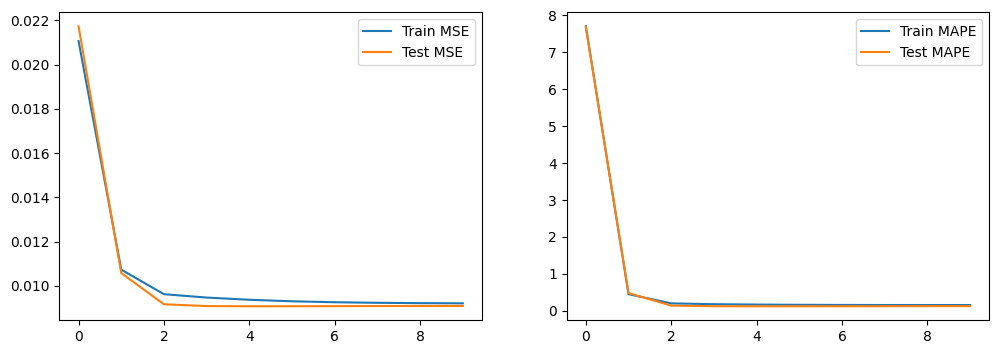

In [178]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

train_metrics = np.array(train_losses).T
test_metrics = np.array(test_losses).T

sns.lineplot(train_metrics[0], label = 'Train MSE', ax=ax[0])
sns.lineplot(test_metrics[0], label = 'Test MSE', ax=ax[0])
sns.lineplot(train_metrics[1], label = 'Train MAPE', ax=ax[1])
sns.lineplot(test_metrics[1], label = 'Test MAPE', ax=ax[1])
plt.legend()
plt.show()

In [179]:
test_set = TorchTSDataset(X_test, look_back)
test_loader = DataLoader(test_set, batch_size = 1024, shuffle = False)

model.eval()
targets = []
total_preds = []
for batch, target in test_loader:
    targets += list(target.detach().numpy().reshape(-1))
    total_preds += list(model(batch).detach().numpy().reshape(-1))

ema = ExponentionalAverager(0.01, 5)
ema_vals = []
for t in targets:
    ema.update(t)
    ema_vals.append(ema.get())

df = pd.DataFrame({'actual': targets,
                   'prediction': total_preds,
                   'exponential_smoothed': ema_vals
                   })
df.reset_index(inplace=True)
df.head(5)

,index,actual,prediction,exponential_smoothed
0,0,0.018885,0.017556,0.012962
1,1,0.018208,0.017151,0.014710
2,2,0.019314,0.018016,0.016245
3,3,0.020090,0.018205,0.017527
4,4,0.019677,0.017207,0.018243


In [180]:
fig = px.line(df[:5000], x='index', y=['actual', 'prediction', 'exponential_smoothed'])
fig.show()